In [1]:
# %load_ext autoreload

In [2]:
# %autoreload 2

In [3]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import timeit
import math

In [4]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

In [5]:
img = aviris.open('f970619t01p02_r02_sc04.a.rfl', 'f970619t01p02_r02.a.spc')

	Data Source:   '/home/marko/HSI/f970619t01p02r02c/f970619t01p02_r02_sc04.a.rfl'
	# Rows:            512
	# Samples:         614
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16
float64


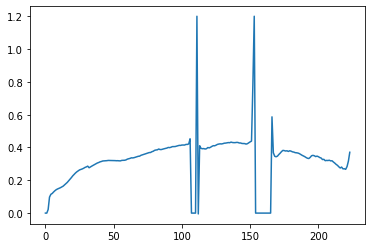

In [6]:
print(img)
print(img[380, 496].dtype)
pylab.plot(img[380, 496])

In [7]:
data = img[:,:,:]
data[data < 0] = 0
data[:, :, 106:115] = 0
data[:, :, 148:169] = 0

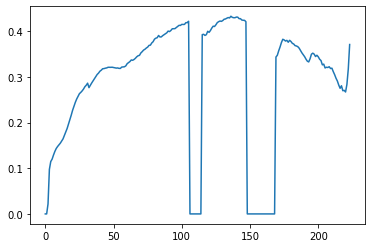

In [8]:
pylab.plot(data[380, 496])

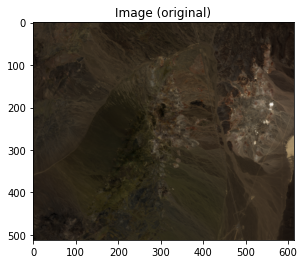

In [9]:
view = imshow(data, (29, 20, 12), title="Image (original)")

In [10]:
wavelengths_original = np.array(img.bands.centers)
wavelengths_sorted = np.sort(wavelengths_original)
resampler = BandResampler(wavelengths_original, wavelengths_sorted, img.bands.bandwidths)
img_width = data.shape[0]
img_height = data.shape[1]
img_depth = data.shape[2]
data = np.dot(data.reshape(img_width*img_height, img_depth), resampler.matrix.T)
data = data.reshape(img_width, img_height, img_depth)
wavelengths = wavelengths_sorted
wavelengths_um = wavelengths / 1000

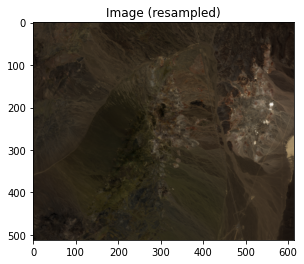

In [11]:
view = imshow(data, (29, 20, 12), title="Image (resampled)")

In [12]:
subdata = data[0:50, 0:50]

Computed continuum of the all the spectra in 0.003927536999981385


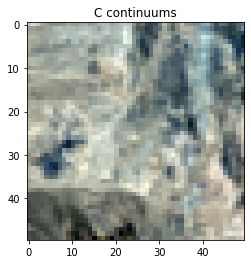

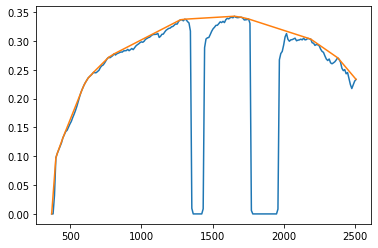

In [13]:
from ccontinuum import continuum
sc_continuums = np.empty((subdata.shape[0] * subdata.shape[1], subdata.shape[2]))

starttime = timeit.default_timer()
continuum(subdata.reshape(sc_continuums.shape), sc_continuums, wavelengths)
sc_continuums = sc_continuums.reshape(subdata.shape)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

imshow(sc_continuums, (29, 20, 12), title="C continuums")
pylab.figure()
pylab.plot(wavelengths, data[4, 7])
pylab.plot(wavelengths, sc_continuums[4, 7])

Computed continuum of the all the spectra in 0.009039263000886422
Result diff from C  1.0886992696246267e-11


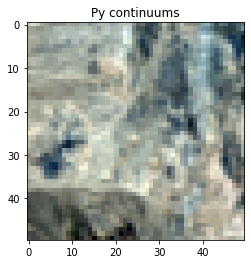

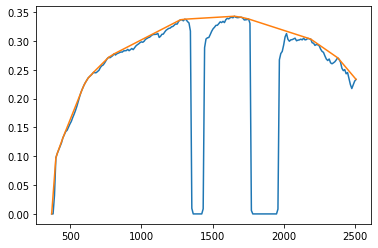

In [16]:
from pycontinuum import continuum
py_continuums = np.empty_like(subdata)

starttime = timeit.default_timer()
continuum(subdata, wavelengths, out=py_continuums)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

print('Result diff from C ', np.linalg.norm((py_continuums - sc_continuums).reshape(-1), 1))

imshow(py_continuums, (29, 20, 12), title="Py continuums")
pylab.figure()
pylab.plot(wavelengths, subdata[4, 7])
pylab.plot(wavelengths, py_continuums[4, 7])

[0.     0.     0.     0.085  0.1017]
[369.85 379.69 389.53 399.37 409.21]
(5,)
(5,)
[(369.85, 0.0), (399.37, 0.085), (409.21, 0.1017)]

[(369.85, 0.0), (399.37, 0.085), (409.21, 0.1017)]


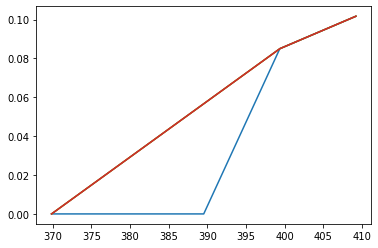

In [18]:
from pycontinuum import find_continuum_points_recursive, find_continuum_points_iterative
import ccontinuum
wls = wavelengths
#spectrum = img[163, 145]
spectrum = data[134, 257]
#wls = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=float)
#spectrum = np.array([1, 2, 2.5, 1.6, 0.75, 1.5, 2.2, 2.9, 1.8])
#wls = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=float)
#spectrum = np.array([1, 2, 2.5, 1.6, 0.75, 1.5, 2.2, 2.9, 1.8])
#wls = np.array([1, 2, 3, 4, 5], dtype=float)
#spectrum = np.array([1, 1.2, 2.5, 1.0, 0.75])
#wls = wavelengths #[0:32]
#spectrum = data[4, 16]
#wls =      np.array([0.30, 1.00, 1.80, 3.00, 4.50, 5.20, 6.45, 7.00, 7.10, 8.00, 8.10, 9.00, 9.30, 10.20, 10.50, 10.6], dtype=float)
#spectrum = np.array([0.60, 1.00, 2.45, 3.10, 3.25, 4.15, 4.35, 4.10, 3.10, 2.70, 2.00, 2.85, 3.75, 3.00, 2.00, 0.90], dtype=float)
spectrum = data[134, 257][:5]
wls = np.arange(len(wavelengths[:5]), dtype=float)
wls = wavelengths[:5]

print(spectrum)
print(wls)

print(spectrum.shape)
print(wls.shape)

indices = np.empty_like(spectrum, dtype=int)
x, y = find_continuum_points_recursive(spectrum, wls, indices)
pylab.plot(wls, spectrum)
pylab.plot(x, y)
x2, y2 = find_continuum_points_iterative(spectrum, wls, indices)
pylab.plot(x2, y2)

ot = np.empty_like(spectrum)
ccontinuum.continuum(spectrum, ot, wls)
pylab.plot(wls, ot)

print(list(zip(x, y)))
print()
print(list(zip(x2, y2)))

Computed continuum of the all the spectra in 0.18168170499848202


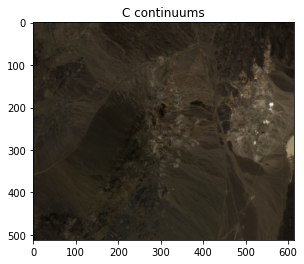

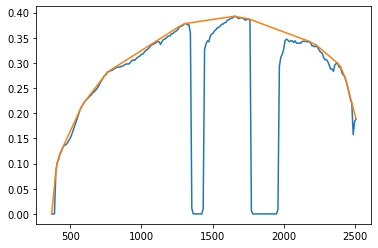

In [20]:
from ccontinuum import continuum
c_continuums = np.empty_like(data)

starttime = timeit.default_timer()
continuum(data, c_continuums, wavelengths)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

imshow(c_continuums, (29, 20, 12), title="C continuums")
pylab.figure()
pylab.plot(wavelengths, data[134, 257])
pylab.plot(wavelengths, c_continuums[134, 257])

Computed continuum of the all the spectra in 0.7287916429995676
Result diff from C  5.134781488891349e-15


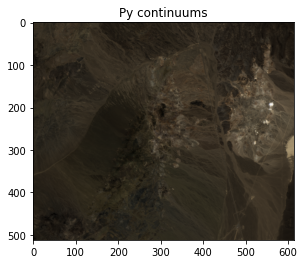

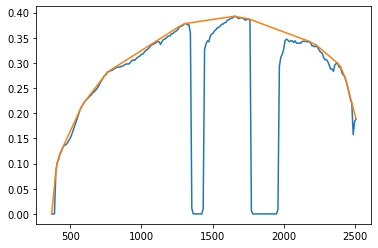

In [22]:
from pycontinuum import continuum
py_continuums = np.empty_like(data)

starttime = timeit.default_timer()
continuum(data, wavelengths, out=py_continuums)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

print('Result diff from C ', np.linalg.norm((py_continuums - c_continuums).reshape(-1), float('inf')))

imshow(py_continuums, (29, 20, 12), title="Py continuums")
pylab.figure()
pylab.plot(wavelengths, data[134, 257])
pylab.plot(wavelengths, py_continuums[134, 257])

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f compute_continuums compute_continuums(subdata, wavelengths, out=py_continuums)